# Behavioral Cloning Project

## 1.* Load the data and preprocess*

In [1]:
# import prerequisites
import os
import cv2
import csv
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# I used the generator object as proprosed in the lession to preprocess the data on the fly
# instead of storing everything to the memory
samples = []
#using a reduced version of the drinving log

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True, delimiter=',')
    for line in reader:
        samples.append(line)
# delete header
del samples[0]
print(len(samples))

9309


### data visualization

Sample images:


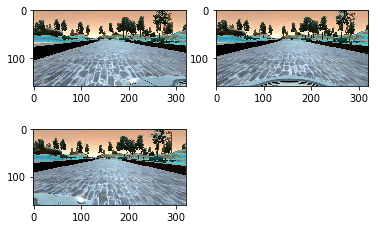

In [3]:

# Get file path from root
center_img = samples[0][0]
left_img = samples[0][1]
right_img = samples[0][2]


# split the strings
center_img = "data/IMG/" + center_img.split("/")[-1]
left_img = "data/IMG/" + left_img.split("/")[-1]
right_img = "data/IMG/" + right_img.split("/")[-1]

# get the pictures
center_img = cv2.imread(center_img)
left_img = cv2.imread(left_img)
right_img = cv2.imread(right_img)

fig = plt.figure()
print("Sample images:")
fig.add_subplot(2,2,1)
plt.imshow(left_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(center_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(right_img.squeeze(), cmap="gray")


#### *Split in train and test data*

In [4]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [5]:
print(len(train_samples))
print(len(validation_samples))

7447
1862


#### generator function

In [6]:
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    correction_value = 0.2
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                for row in range(3):
                    #row 1,2,3 in csv --> mid, left, right           
                    # getting path of image
                    if "2017" in batch_sample[row]:
                        path_img = 'data/IMG/' + batch_sample[row].split('\\')[-1]
                    else:
                        path_img = 'data/IMG/' + batch_sample[row].split('/')[-1]
                    # Save the image in var
                    img = cv2.imread(path_img)
                    img_aug = cv2.flip(img,1)
                    
                    angle = float(batch_sample[3])
                    angle_aug = angle * (-1)
                    
                    # left images
                    if row == 1:
                        # Steer right
                        angle += correction_value
                        angle_aug -= correction_value
                        
                    # right images
                    elif row == 2:  
                        # Steer left
                        angle -= correction_value
                        angle_aug += correction_value
                    # Add the new image and angle to the list
                    images.append(img)
                    angles.append(angle)
                    # Add the new augmented images and angles to the list
                    images.append(img_aug)
                    angles.append(angle_aug)
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

In [7]:
# model
from keras.models import Model, Sequential
from keras.layers import Cropping2D, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.core import Dense, Activation, Flatten

crop_top = 65
crop_bot = 20

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)



Using TensorFlow backend.


In [8]:
model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((crop_top, crop_bot), (0, 0))))

# Layer 1 - Convolutional
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 2 - Convolutional
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 3 - Convolutional
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Dropout(1))

# Layer 4 - Convolutional // changed to 32, was 64
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Dropout(1))

# Layer 5 - Convolutional
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Dropout(0.2))

# Layer 6 - Flatten
model.add(Flatten())

# Layer 7 - Fully Connected
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8 - Fully Connected
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 9 - Fully Connected
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 10 - Fully Connected
model.add(Dense(1))

In [9]:
print(round(len(train_samples)*0.5))

3724


In [10]:
model.compile(loss='mse', optimizer='adam')
#multiplicator = 3

# with augmented images --> multiplicator = 6
#multiplicator = 0.5

EPOCH = 15

history_object = model.fit_generator(train_generator, samples_per_epoch= round(len(train_samples)*0.5), 
                                     validation_data=validation_generator, nb_val_samples=round(len(validation_samples)*0.5), nb_epoch=EPOCH, verbose = 1)



C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda3\envs\tensorflow-with-gpu-10\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=931, epochs=15, steps_per_epoch=3724, verbose=1)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/15
3724/3724 [==============================] - 1844s - loss: 0.0217 - val_loss: 0.0158
Epoch 2/15
3724/3724 [==============================] - 1805s - loss: 0.0158 - val_loss: 0.0148
Epoch 3/15
3724/3724 [==============================] - 1804s - loss: 0.0130 - val_loss: 0.0147
Epoch 4/15
3724/3724 [==============================] - 1801s - loss: 0.0116 - val_loss: 0.0151
Epoch 5/15
3724/3724 [==============================] - 1806s - loss: 0.0108 - val_loss: 0.0151
Epoch 6/15
3724/3724 [==============================] - 1797s - loss: 0.0103 - val_loss: 0.0146
Epoch 7/15
3724/3724 [==============================] - 1797s - loss: 0.0098 - val_loss: 0.0148
Epoch 8/15
3724/3724 [==============================] - 1795s - loss: 0.0096 - val_loss: 0.0146
Epoch 9/15
3724/3724 [==============================] - 1795s - loss: 0.0093 - val_loss: 0.0146
Epoch 10/15
3724/3724 [==============================] - 1793s - loss: 0.0093 - val_loss: 0.0150
Epoch 11/15
3724/3724 [================

dict_keys(['val_loss', 'loss'])
model saved!


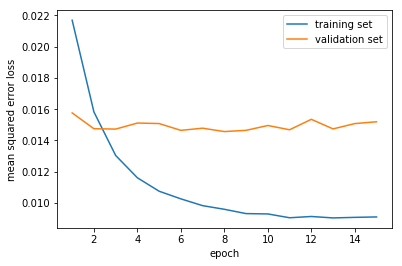

In [11]:
print(history_object.history.keys())
plot_x = np.arange(1, EPOCH+1)
plt.plot(plot_x, history_object.history['loss'])
plt.plot(plot_x, history_object.history['val_loss'])
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('training_vs_validation.png')

# save model
model.save('model.h5')
print("model saved!")